## PACK INSTALLATION (Restart kernel after run)

In [ ]:
# Install the scikit-learn library for machine learning algorithms
pip install scikit-learn

In [ ]:
# Install the xlsxwriter library for creating Excel files
pip install xlsxwriter

## IMPORT

In [18]:
# Import OpenCV and check its version
import cv2
cv2.__version__

'4.5.4'

In [19]:
# Import necessary libraries for image processing, visualization, and machine learning
from PIL import Image

# Napari for interactive visualization
import napari

# General-purpose libraries
import scipy
import csv
import imghdr
import colorsys
import os
import xlsxwriter

# Numerical computations
import numpy as np

# OpenCV for image processing
import cv2 as cv
import matplotlib.pyplot as plt

# PyVista for 3D visualization
import pyvista as pv

# Stardist for deep learning-based segmentation
from csbdeep.utils import normalize
from stardist.models import StarDist2D, Config3D, StarDist3D
from stardist.data import test_image_nuclei_2d
from stardist.plot import render_label

# Scipy and Skimage for image processing and segmentation
from scipy import ndimage as ndi

from skimage import filters
from skimage.draw import disk
from skimage.segmentation import watershed
from scipy.ndimage import distance_transform_edt
from skimage.measure import label, regionprops
from skimage.filters import threshold_local
from scipy.ndimage import center_of_mass

# from skimage.feature import peak_local_max
from vispy.color import Colormap
from IPython.display import display_html
from IPython.display import clear_output

from stardist.models import StarDist2D, Config3D, StarDist3D
from stardist.data import test_image_nuclei_2d
from stardist.plot import render_label

import sklearn
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KernelDensity
from sklearn.svm import OneClassSVM

# Morphological operations for image processing
from skimage.morphology import remove_small_holes, remove_small_objects
from skimage.morphology import closing, square

# Napari settings for interactive visualization
from napari.settings import get_settings
settings = get_settings()

# AICSImageIO for reading and writing image files
from aicsimageio import AICSImage
from tifffile import imwrite

## Functions

In [20]:
def ellipse_pixels(center, semi_axes, rotation, image_shape):
    """
    Generate the pixel coordinates that lie inside an ellipse.

    Parameters:
    - center: Tuple (x, y) representing the center of the ellipse.
    - semi_axes: Tuple (semi_major_axis, semi_minor_axis) representing the lengths of the ellipse's axes.
    - rotation: Rotation angle of the ellipse in radians.
    - image_shape: Shape of the image (height, width) to constrain the ellipse.

    Returns:
    - A 2D array of pixel coordinates (row, column) that lie inside the ellipse.
    """
    # Create a grid of x and y coordinates for the image
    y, x = np.meshgrid(np.arange(imarray.shape[1]), np.arange(imarray.shape[0]), indexing='xy')
    
    # Compute the cosine and sine of the rotation angle
    cos_theta = np.cos(rotation)
    sin_theta = np.sin(rotation)
    
    # Rotate the x and y coordinates to align with the ellipse's axes
    x_rot = cos_theta * (x - center[0]) + sin_theta * (y - center[1])
    y_rot = -sin_theta * (x - center[0]) + cos_theta * (y - center[1])

    # Create a mask for pixels that lie inside the ellipse
    mask = (x_rot / semi_axes[0])**2 + (y_rot / semi_axes[1])**2 <= 1

    # Enable interactive mode for Napari (if needed)
    settings.application.ipy_interactive = True

    # Return the coordinates of the pixels inside the ellipse
    return np.column_stack(np.where(mask))

def rgb_to_hsv(rgb_array):
    """
    Convert an array of RGB values to HSV (Hue, Saturation, Value).

    Parameters:
    - rgb_array: A 2D array where each row is an RGB triplet (R, G, B).

    Returns:
    - A 2D array where each row is an HSV triplet (H, S, V).
      H is in degrees (0-360), S and V are percentages (0-100).
    """
    hsv_list = []
    for rgb in rgb_array:
        r, g, b = rgb  # Extract the RGB components
        h, s, v = colorsys.rgb_to_hsv(r, g, b)  # Convert RGB to HSV
        hsv_list.append([h * 360, s * 100, v * 100])  # Scale H to degrees, S and V to percentages
    return np.array(hsv_list)

def csv_to_matrix(file_path):
    """
    Read a CSV file and convert its contents into a matrix.

    Parameters:
    - file_path: Path to the CSV file.

    Returns:
    - A 2D list where each row corresponds to a row in the CSV file.
    """
    matrix = []
    with open(file_path, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            # Convert numeric values to integers, leave others as strings
            matrix.append([int(value) if value.replace('.', '', 1).isdigit() else value for value in row])
    return matrix

def classify_points(cloud_points, test_points, bandwidth=1.0):
    """
    Classify test points based on their similarity to a cloud of points using Kernel Density Estimation (KDE).

    Parameters:
    - cloud_points: A 2D array of points representing the training data.
    - test_points: A 2D array of points to classify.
    - bandwidth: Bandwidth parameter for the KDE (controls smoothness).

    Returns:
    - A 1D array of probabilities for each test point.
    """
    # Fit a Kernel Density Estimator to the cloud points
    kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
    kde.fit(cloud_points)
    
    # Evaluate the probability density for each test point
    log_density = kde.score_samples(test_points)
    
    # Convert log-density to probabilities
    probabilities = np.exp(log_density)
    return probabilities

## File upload
Write the name of the file that needs to be investigated.

In [21]:
# Define the TIFF file to be processed
tiff_file = '1IL1_2.tif'

# Extract the file name without the extension
tiff_stem = os.path.splitext(os.path.basename(tiff_file))[0]

# Open the TIFF file as an image
img = Image.open(tiff_file)

# Convert the image to a NumPy array for further processing
imarray = np.array(img)

# Print the shape of the image array (dimensions of the image)
print(imarray.shape)

(309, 489, 3)


In [22]:
r_X=0.698 #um, 10X
r_Y=0.698 #um, 10X

## ROI 
This section will find the region of interest by checking the blue part. 

#### If the image is RGBA and we only want RGB, remove A channel

In [23]:
# Remove alpha channel if present
if imarray.shape[2] == 4:
    imarray = imarray[:, :, :3]

Variables: [step] will dictate the size of the square of investigation (smaller values will get a better resolution but slower run), [delta] will dictate the sensitivity of the blue level (smaller values lead to more false positive but higher values lead to more false negative).  

In [24]:
# Create a copy of the original image to define the ROI (Region of Interest)
ROI_image = imarray.copy()

# Initialize a mask image with the same dimensions as the green channel of the original image
mask_image = np.zeros(np.shape(imarray[:, :, 1]))

# Define parameters for the investigation
step = 30  # Size of the square for investigation
delta = 1  # Sensitivity for blue dominance
holes_threshold = 1000  # Minimum area to consider a hole
island_threshold = 1000  # Minimum size to consider an object

# Iterate through the image in steps to identify blue-dominant regions
for i in range(1 + step, imarray.shape[0], step):
    for j in range(1 + step, imarray.shape[1], step):
        # Check if the blue channel is dominant over both red and green channels
        if (
            np.mean(ROI_image[i-step:i+step, j-step:j+step, 2]) >= delta + np.mean(ROI_image[i-step:i+step, j-step:j+step, 1]) and
            np.mean(ROI_image[i-step:i+step, j-step:j+step, 2]) >= delta + np.mean(ROI_image[i-step:i+step, j-step:j+step, 0])
        ):
            # Mark the region as part of the mask
            mask_image[i:i+step, j:j+step] = 1

# Fill small holes in the mask to create a more continuous region
mask_filled = remove_small_holes(mask_image.astype(int), area_threshold=holes_threshold, connectivity=1)

# Remove small isolated objects from the mask
mask_filled = remove_small_objects(mask_filled, min_size=island_threshold, connectivity=1)

# Apply the mask to the original image to isolate the ROI
ROI_image = imarray * np.stack([mask_filled] * 3, axis=2)

1233810034.py (25): Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?


In [25]:
settings.application.ipy_interactive = True

viewer_0 = napari.Viewer()

viewer_0.add_image(imarray, name='Original', 
                colormap='grey', blending='additive')
viewer_0.add_image(mask_filled, name='Violet', 
                colormap='green', blending='additive')

<Image layer 'Violet' at 0x7339381364d0>

### Training image
Choose the image that will be used as training. It will be opened in Napari. Choose the circular selection on the right and choose as many nuclei as possible to train the algorithm. Then close the Napari window to continue

In [26]:
# Define the training file and extract its name without the extension
training_file = '10Xcow1_IL1_4_zoom.tif'
training_stem = os.path.splitext(os.path.basename(training_file))[0]

# Flag to determine whether to use an existing CSV file for training points
use_csv = True

# Check if the CSV file with training points exists
if use_csv and os.path.exists(training_stem + '_yes_points.csv'):
    # Load training points from the CSV file
    yes_points = csv_to_matrix(training_stem + '_yes_points.csv')
else:
    # Initialize an empty list for training points
    yes_points = []
    
    # Create an empty label array for the ROI
    ROI_labels = np.zeros(trainarray.shape)
    
    # Disable interactive mode for Napari
    settings.application.ipy_interactive = False
    
    # Open the training image in Napari for manual annotation
    viewer_c = napari.Viewer()
    viewer_c.add_image(trainarray, name='Original', 
                       colormap='grey', blending='additive')
    
    # Callback function to handle shape addition in Napari
    def on_shape_added(layer, event):
        shapes_layer = event.source

    # Add a shapes layer for annotating nuclei
    shapes_layer = viewer_c.add_shapes(shape_type="circle", name="Nuclei training")
    
    # Connect the mouse drag event to the callback function
    viewer_c.mouse_drag_callbacks.append(on_shape_added)
    
    # Run Napari for manual annotation
    napari.run()

    # Process each annotated shape to extract training points
    for s in range(0, np.shape(shapes_layer.data)[0]):
        # Get the bounding box of the shape
        xmax = np.max(shapes_layer.data[s][:, 0])
        ymax = np.max(shapes_layer.data[s][:, 1])
        xmin = np.min(shapes_layer.data[s][:, 0])
        ymin = np.min(shapes_layer.data[s][:, 1])
    
        # Calculate ellipse parameters
        center = ((xmax + xmin) / 2, (ymax + ymin) / 2)  # Center of the ellipse
        semi_axes = (
            abs(xmax - xmin) / 2,  # Semi-major axis (height / 2)
            abs(ymax - ymin) / 2,  # Semi-minor axis (width / 2)
        )
        rotation = 0  # Napari's ellipses are axis-aligned by default
    
        # Get the shape of the training image
        image_shape = trainarray.shape
    
        # Get the pixel coordinates inside the ellipse
        enclosed_pixels = ellipse_pixels(center, semi_axes, rotation, image_shape[:2])

        # If the CSV file exists, load the existing training points
        if os.path.exists(training_stem + '_yes_points.csv'):
            yes_points = csv_to_matrix(training_stem + '_yes_points.csv')
    
        # Add the RGB values of the enclosed pixels to the training points
        for i in range(enclosed_pixels.shape[0]):
            x = enclosed_pixels[i][0]
            y = enclosed_pixels[i][1]
            yes_points.append([trainarray[x, y, 0], trainarray[x, y, 1], trainarray[x, y, 2]])

        # Save the updated training points to the CSV file
        with open(training_stem + '_yes_points.csv', 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerows(yes_points)

# Convert the training points to a NumPy array for further processing
yes_points = np.array(yes_points)

Text(0, 0.5, 'BLUE')

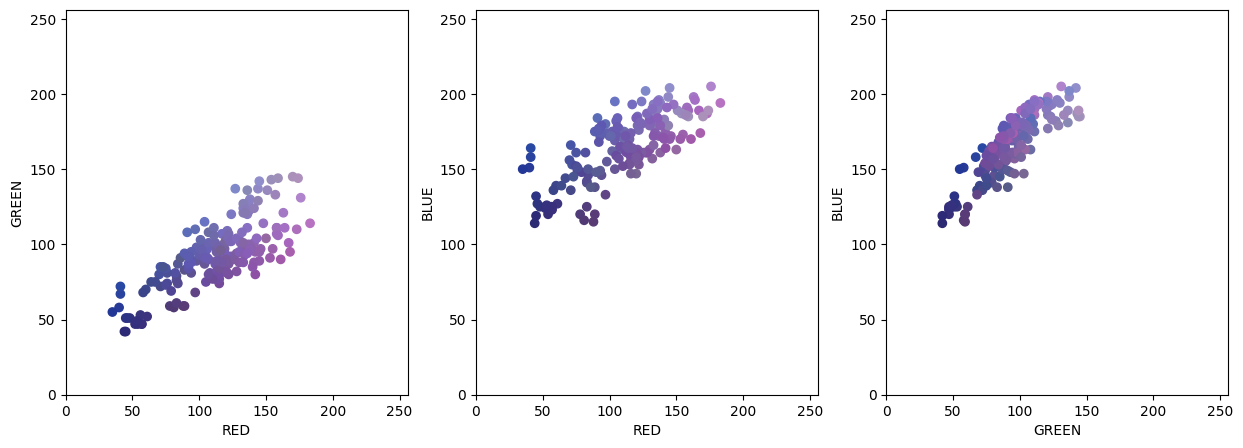

In [27]:
## Visualize distribution of training points

fig, axs = plt.subplots(1,3,figsize=(15,5))
axs[0].scatter(yes_points[:,0],yes_points[:,1], c = yes_points/255)
axs[0].set_xlim((0,256))
axs[0].set_xlabel("RED")
axs[0].set_ylim((0,256))
axs[0].set_ylabel("GREEN")
axs[1].scatter(yes_points[:,0],yes_points[:,2], c = yes_points/255)
axs[1].set_xlim((0,256))
axs[1].set_xlabel("RED")
axs[1].set_ylim((0,256))
axs[1].set_ylabel("BLUE")
axs[2].scatter(yes_points[:,1],yes_points[:,2], c = yes_points/255)
axs[2].set_xlim((0,256))
axs[2].set_xlabel("GREEN")
axs[2].set_ylim((0,256))
axs[2].set_ylabel("BLUE")

Text(0, 0.5, 'V')

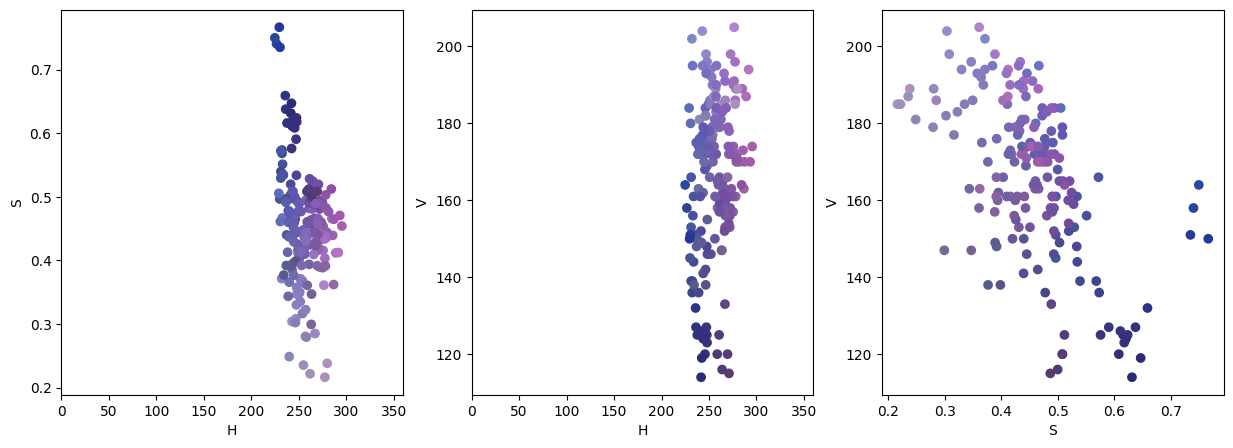

In [28]:
## Visualize distribution of training points
yes_points_hsv=rgb_to_hsv(yes_points)

fig, axs = plt.subplots(1,3,figsize=(15,5))
axs[0].scatter(yes_points_hsv[:,0],yes_points_hsv[:,1]/100.0, c = yes_points/255)
axs[0].set_xlim((0,360))
axs[0].set_xlabel("H")
#axs[0].set_ylim((0,100))
axs[0].set_ylabel("S")
axs[1].scatter(yes_points_hsv[:,0],yes_points_hsv[:,2]/100.0, c = yes_points/255)
axs[1].set_xlim((0,360))
axs[1].set_xlabel("H")
#axs[1].set_ylim((0,100))
axs[1].set_ylabel("V")
axs[2].scatter(yes_points_hsv[:,1]/100.0,yes_points_hsv[:,2]/100.0, c = yes_points/255)
#axs[2].set_xlim((0,100))
axs[2].set_xlabel("S")
#axs[2].set_ylim((0,100))
axs[2].set_ylabel("V")

After you run the next section, a new Napari window will appear with highlighted in green all the nuclei in the ROI.

In [29]:
# Enable interactive mode for Napari
settings.application.ipy_interactive = True

# Create a copy of the ROI image for processing
imarray0 = ROI_image.copy()

# Extract the red, green, and blue channels from the ROI image
imR = imarray0[:, :, 0]
imG = imarray0[:, :, 1]
imB = imarray0[:, :, 2]

# Convert the training points from RGB to HSV
yes_points_hsv = rgb_to_hsv(yes_points)

# Scale the HSV training points for better performance in the SVM
scaler = StandardScaler()
yes_points_scaled = scaler.fit_transform(yes_points_hsv)

# Set up the One-Class SVM for anomaly detection
sensitivity = 0.7  # Sensitivity level (e.g., 10% of points allowed as outliers)
clf = OneClassSVM(kernel='rbf', nu=sensitivity, gamma='scale')
clf.fit(yes_points_scaled)

# Initialize an empty array for the violet channel
imV = np.zeros(np.shape(imR))

# Initialize a counter for progress tracking
tval = 0

# Iterate through the image to classify each pixel
for i in range(step, np.shape(imV)[0]):
    for j in range(step, np.shape(imV)[1]):
        tval += 1
        # Process only pixels within the mask
        if mask_filled[i, j] > 0:
            # Extract RGB values of the current pixel
            pR = imR[i, j]
            pG = imG[i, j]
            pB = imB[i, j]
            X = np.array([[pR, pG, pB]])

            # Convert the pixel to HSV and scale it
            X_hsv = rgb_to_hsv(X)
            X_scaled = scaler.transform(X_hsv)

            # Classify the pixel using the KDE-based classifier
            predictions = classify_points(yes_points_hsv, X_hsv, bandwidth=20.0)

            # Assign the prediction value to the violet channel
            if predictions > 0.0:
                imV[i, j] = predictions[0]
            else:
                imV[i, j] = 0
        else:
            j += step  # Skip to the next step if outside the mask

        # Display progress at regular intervals
        if (100.0 * tval / (np.shape(imV)[0] * np.shape(imV)[1]) % 1.0 == 0.0):
            clear_output(wait=True)
            print('PROGRESS ' + str(100.0 * tval / (np.shape(imV)[0] * np.shape(imV)[1])) + ' %')

# Visualize the results in Napari
viewer_0 = napari.Viewer()

# Add the ROI image to the viewer
viewer_0.add_image(imarray0, name='ROI', 
                   colormap='grey', blending='additive')

# Add the violet channel (classification results) to the viewer
viewer_0.add_image(imV, name='Violet', 
                   colormap='green', blending='additive')

<Image layer 'Violet' at 0x733937735630>

#### Remove noise and big regions

In [31]:
#🔹 Step 1: Thresholding: switch from grayscale to binary scale (different brightness to either 0 for background or 1 for nuclei)
# Get all nonzero values in imV (ignoring background)
valid_pixels = imV[imV > 0]  

# Compute the 98th percentile threshold only for these valid pixels
if len(valid_pixels) > 0:  # Ensure there are nonzero pixels
    threshold_value = np.percentile(valid_pixels, 95.0)  
    binary_mask = (imV >= threshold_value)  # Keep only the top 2% brightest pixels
else:
    binary_mask = np.zeros_like(imV)  # If no valid pixels, return empty mask

# Visualization
viewer_1 = napari.Viewer()
viewer_1.add_image(imarray, name='Original', colormap='grey', blending='additive')
viewer_1.add_image(imarray0, name='ROI', colormap='grey', blending='additive')
viewer_1.add_image(imV, name='Violet', colormap='green', blending='additive')
viewer_1.add_image(binary_mask.astype(float), name="Thresholded", colormap="blue", blending="additive")

napari.run()

In [32]:
# Step 2: Remove Noise & Artifacts
binary_mask2 = remove_small_objects(binary_mask, min_size=5)  
binary_mask2 = closing(binary_mask2, square(3))  # Fills small holes and connects nearby white regions.

# Visualization
viewer_2 = napari.Viewer()
viewer_2.add_image(imarray, name='Original', colormap='grey', blending='additive')
viewer_2.add_image(imarray0, name='ROI', colormap='grey', blending='additive')
viewer_2.add_image(imV, name='Violet', colormap='green', blending='additive')
viewer_2.add_image(binary_mask.astype(float), name="Thresholded", colormap="blue", blending="additive")
viewer_2.add_image(binary_mask2.astype(float), name="Noise_removed", colormap="blue", blending="additive")

napari.run()

In [33]:
# Step 3: Remove Artifacts Based on Size
# Define the minimum and maximum size for nuclei to be considered valid
min_nucleus_size = 1  # Minimum size of a nucleus
max_nucleus_size = 130  # Maximum size of a nucleus

# Initialize an empty mask to store the filtered regions
filtered_mask = np.zeros_like(binary_mask2)

# Iterate through each connected region in the labeled binary mask
for region in regionprops(label(binary_mask2)):
    # Check if the region's area falls within the valid size range
    if min_nucleus_size <= region.area <= max_nucleus_size:
        # Add the region to the filtered mask
        filtered_mask[label(binary_mask2) == region.label] = 1

# Visualization
viewer_3 = napari.Viewer()
viewer_3.add_image(imarray, name='Original', colormap='grey', blending='additive')
viewer_3.add_image(imarray0, name='ROI', colormap='grey', blending='additive')
viewer_3.add_image(imV, name='Violet', colormap='green', blending='additive')
viewer_3.add_image(binary_mask.astype(float), name="Thresholded", colormap="blue", blending="additive")
viewer_3.add_image(binary_mask2.astype(float), name="Noise_removed", colormap="blue", blending="additive")
viewer_3.add_image(filtered_mask.astype(float), name="Big_removed", colormap="blue", blending="additive")

napari.run()

In [34]:
# Step 4: Watershed for Better Separation
# Compute the distance transform of the filtered mask
distance = distance_transform_edt(filtered_mask)

# Create markers for the watershed algorithm based on the distance transform
# Markers are created where the distance is greater than a small fraction of the maximum distance
markers = label(distance > 0.0001 * distance.max())

# Apply the watershed algorithm to segment nuclei
# The negative distance is used to ensure that the watershed grows from the markers
segmented_nuclei = watershed(-distance, markers, mask=filtered_mask)

# Visualization
viewer_4 = napari.Viewer()
viewer_4.add_image(imarray, name='Original', colormap='grey', blending='additive')
viewer_4.add_image(imarray0, name='ROI', colormap='grey', blending='additive')
viewer_4.add_image(imV, name='Violet', colormap='green', blending='additive')
viewer_4.add_image(binary_mask.astype(float), name="Thresholded", colormap="blue", blending="additive")
viewer_4.add_image(filtered_mask.astype(float), name="Noise_removed", colormap="blue", blending="additive")
viewer_4.add_image(filtered_mask.astype(float), name="Big_removed", colormap="blue", blending="additive")
viewer_4.add_labels(segmented_nuclei, name="Segmented Nuclei")
napari.run()


In [35]:
#🔹 Step 5: Filter by Roundness (Elongation Ratio)

# Define the maximum allowed elongation ratio for roundness filtering
max_ratio = 3.0  # Maximum allowed elongation ratio (major_axis / minor_axis)

# Initialize an empty mask to store the filtered segments
filtered_segments = np.zeros_like(segmented_nuclei)  # Empty mask for valid segments

# Initialize a counter for assigning new labels to filtered segments
k = 1

# Iterate through each connected region in the segmented nuclei
for region in regionprops(segmented_nuclei):
    # Ensure the minor axis length is greater than zero to avoid division by zero
    if region.minor_axis_length > 0:
        # Calculate the elongation ratio (major axis length / minor axis length)
        elongation_ratio = region.major_axis_length / region.minor_axis_length
        
        # Check if the elongation ratio is within the acceptable range
        if elongation_ratio <= max_ratio:
            # Assign a new label to the region in the filtered segments mask
            filtered_segments[segmented_nuclei == region.label] = k
            k += 1  # Increment the label counter

# Visualization
viewer_5 = napari.Viewer()
viewer_5.add_image(imarray, name='Original', colormap='grey', blending='additive')
viewer_5.add_image(imarray0, name='ROI', colormap='grey', blending='additive')
viewer_5.add_image(imV, name='Violet', colormap='green', blending='additive')
viewer_5.add_image(binary_mask.astype(float), name="Thresholded", colormap="blue", blending="additive")
viewer_5.add_image(filtered_mask.astype(float), name="Noise_removed", colormap="blue", blending="additive")
viewer_5.add_image(filtered_mask.astype(float), name="Big_removed", colormap="blue", blending="additive")
viewer_5.add_labels(segmented_nuclei, name="Segmented Nuclei")
viewer_5.add_labels(filtered_segments, name="Filtered by Roundness")
napari.run()

### Output 
Creates a .tiff file with multiple pages. P1 is the original image, P2 is the ROI chosen as the tissue, P3 is the detected nuclei.

In [36]:
# Convert the original image array to an RGB image
rgb_im = Image.fromarray(imarray.astype(np.uint8), mode="RGB")

# Convert the ROI image array to an RGB image
rgb0_im = Image.fromarray(imarray0.astype(np.uint8), mode="RGB")

# Initialize an empty RGB array for the filtered segments
filtered_segments_rgb = np.zeros((np.shape(filtered_segments)[0], np.shape(filtered_segments)[1], 3))

# Generate random colors for each segment label
cmd = np.random.rand(np.max(filtered_segments) + 1, 3)
cmd[0, :] = [0.0, 0.0, 0.0]  # Ensure the background (label 0) is black

# Assign colors to each pixel based on its segment label
for i in range(1, np.shape(filtered_segments)[0]):
    for j in range(1, np.shape(filtered_segments)[1]):
        filtered_segments_rgb[i, j, 0] = int(cmd[filtered_segments[i, j], 0] * 255.0)  # Red channel
        filtered_segments_rgb[i, j, 1] = int(cmd[filtered_segments[i, j], 1] * 255.0)  # Green channel
        filtered_segments_rgb[i, j, 2] = int(cmd[filtered_segments[i, j], 2] * 255.0)  # Blue channel

# Convert the RGB array to uint8 format
filtered_segments_rgb = filtered_segments_rgb.astype('uint8')

# Convert the filtered segments RGB array to an image
b_im = Image.fromarray(filtered_segments_rgb, mode="RGB")

# Save the original image, ROI image, and filtered segments image in a single multi-page TIFF file
output_path = tiff_stem + "_output.tiff"
rgb_im.save(output_path, save_all=True, append_images=[rgb0_im, b_im])

# Print the output file path
print(f"TIFF file saved at: {output_path}")

TIFF file saved at: 1IL1_2_output.tiff


### QUANTIFICATION

In [ ]:
from scipy.ndimage import label, center_of_mass

# Get unique labels from the filtered segments (excluding the background label 0)
labels = np.unique(filtered_segments)
labels = labels[labels != 0]

# Print the total number of nuclei detected
print('TOTAL NUCLEI ' + str(len(labels+1)))

# Compute the centroids (barycenters) of each nucleus
barycenters = {label: center_of_mass(filtered_segments == label) for label in labels}

# Compute the area of each nucleus in square micrometers
areas = {label: np.sum(filtered_segments == label) * r_X * r_Y for label in labels}

# Convert barycenters to a dictionary of coordinates in micrometers
barycenter_coords = {k: (round(v[0], 2) * r_X, round(v[1], 2) * r_Y) for k, v in barycenters.items()}

# Calculate the total area of the image in square micrometers
fullA = np.prod(np.shape(mask_image)) * r_X * r_Y

# Calculate the total area of the ROI in square micrometers
roiA = np.sum(mask_image) * r_X * r_Y

# Print the total area of the image and the ROI
print("TOTAL AREA IMAGE %.2e um2" % fullA)
print("TOTAL AREA ROI %.2e um2" % roiA)

# Calculate the concentration of cells in the ROI (cells per square micrometer)
roiCON = (len(labels+1)) / roiA

# Print the cell concentration in the ROI
print("CELL CONCENTRATION in ROI %.2e cells/um2" % roiCON)

In [ ]:
# Create a new Excel workbook
workbook = xlsxwriter.Workbook(tiff_stem + '.xlsx')

## FORMATS
# Define a format for headers (bold text with yellow background)
header = workbook.add_format({'bold': True})
header.set_bg_color('yellow')

# Define a format for floating-point numbers
floats = workbook.add_format({'num_format': '0.00'})

# Define a format for exponential numbers
exp = workbook.add_format()
exp.set_num_format(11)

## CELLS
# Create a worksheet for cell data
worksheet_cell = workbook.add_worksheet('Cells')

# HEADER
# Write the header row for the 'Cells' worksheet
worksheet_cell.write_row('A1:E1', ['#ID', 'X [um]', 'Y [um]', 'Area Nuclei [um2]'], header)

# CONTENT
# Write the data for each nucleus
for row, value in enumerate(labels):
    worksheet_cell.write(row + 1, 0, value)  # Write nucleus ID
    worksheet_cell.write(row + 1, 1, barycenter_coords[value][0], floats)  # Write X coordinate
    worksheet_cell.write(row + 1, 2, barycenter_coords[value][1], floats)  # Write Y coordinate
    worksheet_cell.write(row + 1, 3, areas[value], floats)  # Write area of the nucleus
    clear_output(wait=True)  # Clear the output to show progress
    print('NUCLEI ' + str(row + 1) + ' / ' + str(len(labels + 1)))  # Print progress

## ROI SHEET
# Create a worksheet for ROI data
worksheet_ROI = workbook.add_worksheet('ROI')

# HEADER
# Write the header row for the 'ROI' worksheet
worksheet_ROI.write_row('A1:E1', ['# NUCLEI', 'TOT AREA [um2]', 'ROI AREA [um2]', 'CONC NUCLEI in ROI [cells/um2]'], header)

# CONTENT
# Write the ROI data
worksheet_ROI.write(1, 0, len(labels + 1))  # Write the total number of nuclei
worksheet_ROI.write(1, 1, fullA, exp)  # Write the total area of the image
worksheet_ROI.write(1, 2, roiA, exp)  # Write the total area of the ROI
worksheet_ROI.write(1, 3, roiCON, exp)  # Write the cell concentration in the ROI

# Close the workbook to save the file
workbook.close()